In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions

print ('Success')

Welcome to JupyROOT 6.24/06
Success


# Reading in .pkl files

In [2]:
Params = {"Run":"run1", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":"overlay",
          "Load_standard_bkgs":True,
          "Load_DetVars":False,
          "Only_keep_common_DetVar_evs":True,
          "Load_Signal_DetVars":False,
          "Load_data":True,
          "FLATTEN":False, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":True, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "Load_truth_vars":False,
          "Load_lepton_signal":True,
          "Load_pi0_signal":False}

Params, samples = Functions.create_sample_list(Params)
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"

Loading these run1 samples: 
['signal', 'overlay', 'dirtoverlay', 'beamoff', 'beamgood']


In [3]:
samples_dict = {}

for sample in samples:
    if sample in Constants.Detector_variations:
        file = pd.read_pickle(loc_pkls+"DetVars/overlay_"+Params["Run"]+"_"+Params["variables_string"]+f"_{sample}_"+Params["Flat_state"]+"_"+Params["Reduced_state"]+".pkl")
        samples_dict[sample] = file
    if Params["Load_Signal_DetVars"] == True:
        file = pd.read_pickle(loc_pkls+"Signal_DetVars/"+Params["Run"]+f"_{sample}_"+Params["Reduced_state"]+".pkl")
        samples_dict[sample] = file
    else:
        if sample == 'signal':
            for HNL_mass in Constants.HNL_mass_samples:
                file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
                samples_dict[HNL_mass] = file
        elif sample == 'pi0_signal':
            for HNL_mass in Constants.HNL_mass_pi0_samples:
                file = pd.read_pickle(loc_pkls+f"{sample}_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
                samples_dict[str(HNL_mass)+"_pi0"] = file
        elif (Params["Load_single_file"] == True) and (isinstance(sample,int)):
            HNL_mass = sample
            file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
            samples_dict[HNL_mass] = file
        else: 
            file = pd.read_pickle(loc_pkls+f"{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
            samples_dict[sample] = file

print(samples_dict.keys())

dict_keys([2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245, 'overlay', 'dirtoverlay', 'beamoff', 'beamgood'])


In [4]:
def Apply_swtrig(df):
    query="swtrig_pre>0"
    df.query(query)

def Apply_flash_shift(df, sample_type):
    #Only required for beam off, overlay, dirtoverlay and signal (i.e all except beamon data)
    if(sample_type=="beamoff"): df["flash_time"]=df["flash_time"] -0.359
    else: df["flash_time"]=df["flash_time"] - 0.304

In [5]:
for sample in samples_dict:
    Apply_swtrig(samples_dict[sample])
    Apply_flash_shift(samples_dict[sample], sample)

# Plotting variables before preselection

In [6]:
#Want to have arrows drawn on for where the preselection cut goes
HNL_mass = 245
if Params["Load_pi0_signal"]:
    HNL_mass = f"{HNL_mass}_pi0" #only plotting one at a time
# else:
    # HNL_mass = 240
variable = 'topological_score'
samples_plotting = {"overlay":samples_dict["overlay"],
                    "dirtoverlay":samples_dict["dirtoverlay"],
                    "beamoff":samples_dict["beamoff"],
                    "signal":samples_dict[HNL_mass]}
if Params["Run"] == "run1":
    sample_norms = {"overlay":Constants.SF_overlay_run1,
                    "dirtoverlay":Constants.SF_dirt_run1,
                    "beamoff":Constants.SF_EXT_run1,
                    "signal":Constants.run1_POT_scaling_dict[HNL_mass]}
elif Params["Run"] == "run3":
    sample_norms = {"overlay":Constants.SF_overlay_run3,
                    "dirtoverlay":Constants.SF_dirt_run3,
                    "beamoff":Constants.SF_EXT_run3,
                    "signal":Constants.run3_POT_scaling_dict[HNL_mass]}

# sample_errors = {"overlay":,
#                  "dirtoverlay":Constants.SF_dirt_run3,
#                  "beamoff":Constants.SF_EXT_run3,
#                  "signal":Constants.run3_POT_scaling_dict[HNL_mass]}

if Params["Load_data"] == True:
    data_dict = {"beamgood":samples_dict["beamgood"]}
    data_norm = {"beamgood":1.0} #No scaling as this is data, should have scaled MC to this POT.
    samples_plotting.update(data_dict)
    sample_norms.update(data_norm)
    
PT.HNL_scaling_calculator(samples_plotting,sample_norms)


The ratio of overlay to HNL events is 4349

The ratio of all bkgs to HNL events is 36878



In [7]:
for sample in samples_plotting:
    print(sample)
    
print(Constants.Preselection_dict_for_plot)

overlay
dirtoverlay
beamoff
signal
beamgood
{'nslice': 'nslice==1', 'flash_time': 'flash_time > 6.55 and flash_time < 16.5', 'nu_flashmatch_score': 'nu_flashmatch_score < 15', 'NeutrinoEnergy2': 'NeutrinoEnergy2 < 500', 'contained_fraction': 'contained_fraction > 0.9', 'trk_score': 'trk_score < 0.97', 'n_pfps': 'n_pfps < 6'}


## Plot data

In [12]:
#Calculate sys
Calculate_sys = False
variable = 'flash_time'


In [36]:
a = np.array([1, 2.5, 3, np.nan, np.nan])

b = np.nan_to_num(a)

print(a)
print(b)

[1.  2.5 3.  nan nan]
[1.  2.5 3.  0.  0. ]


In [47]:
reload(PT)
reload(Functions)

<module 'Utilities.Functions' from '/home/david/HNL/ee_decays/Utilities/Functions.py'>

/home/david/HNL/ee_decays/Utilities/Plotter.py:253: RuntimeWarning: invalid value encountered in true_divide
  dat_err=np.sqrt(x1)*np.nan_to_num(x/x1)
/home/david/HNL/ee_decays/Utilities/Plotter.py:315: RuntimeWarning: invalid value encountered in true_divide
  fracer_data=np.nan_to_num(np.sqrt(x1)/x1)
/home/david/HNL/ee_decays/Utilities/Plotter.py:317: RuntimeWarning: invalid value encountered in true_divide
  fracer_mc=tot_mcerr/plot[0][2]
/home/david/HNL/ee_decays/Utilities/Plotter.py:320: RuntimeWarning: invalid value encountered in true_divide
  rat=np.nan_to_num(x/plot[0][2])


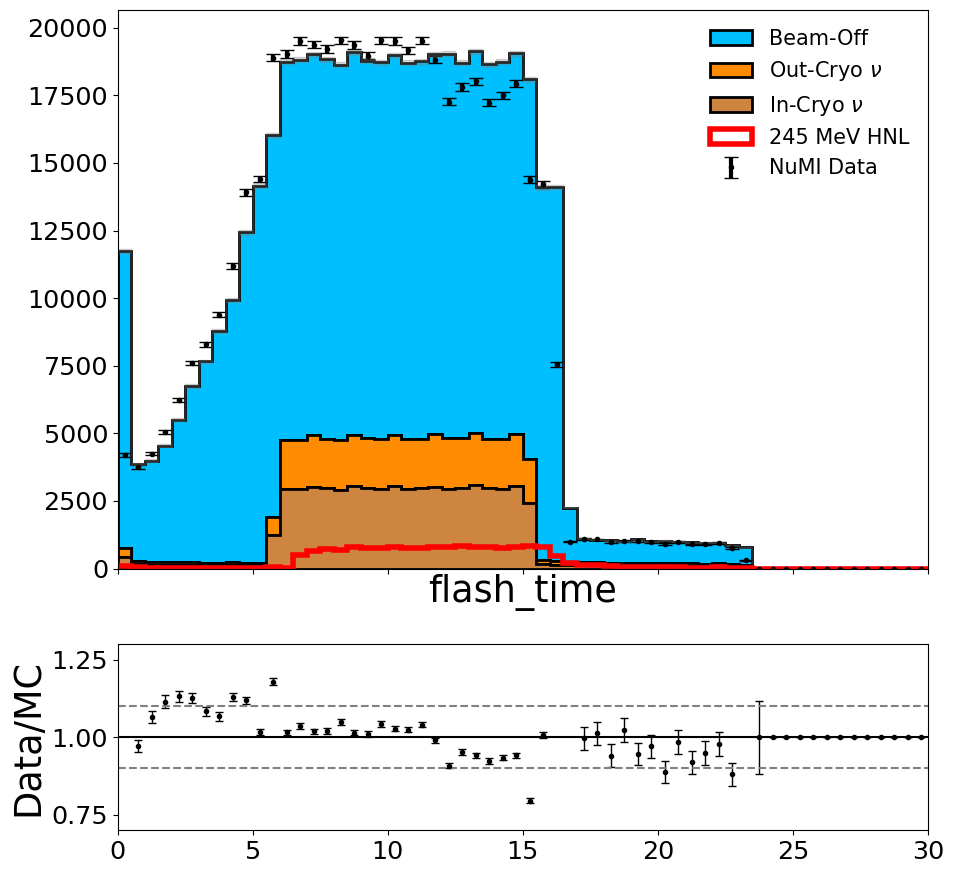

In [48]:
# variable = 'contained_fraction'
PT.Plot_preselection_variable_data(variable, samples_plotting, sample_norms, xlabel=[],xlims=[0,30],bins=60, HNL_mass=HNL_mass,
                              HNLplotscale=1000,cutline=0.0,legloc="upper right", show_ev_nums=False, CalcSys=Calculate_sys)
# plt.axvline(x=16.5, lw=3, color='green', linestyle = 'dashed')

# plt.savefig("plots/Preselection_variables/" + Params["Run"] + "_" + str(HNL_mass) + "_MeV_" + str(variable)+".png")
# plt.savefig("plots/Data_MC_comparison/" + Params["Run"] + "_" + str(HNL_mass) + "_MeV_" + str(variable)+"_shifted_w_swtrig.png")

In [23]:
Highest_E_placeholder = Functions.only_keep_highest_E(samples_dict[HNL_mass])

samples_plotting = {"overlay":samples_dict["overlay"],
           "dirtoverlay":samples_dict["dirtoverlay"],
           "beamoff":samples_dict["beamoff"],
           "signal":Highest_E_placeholder}

## Plotting only highest E object

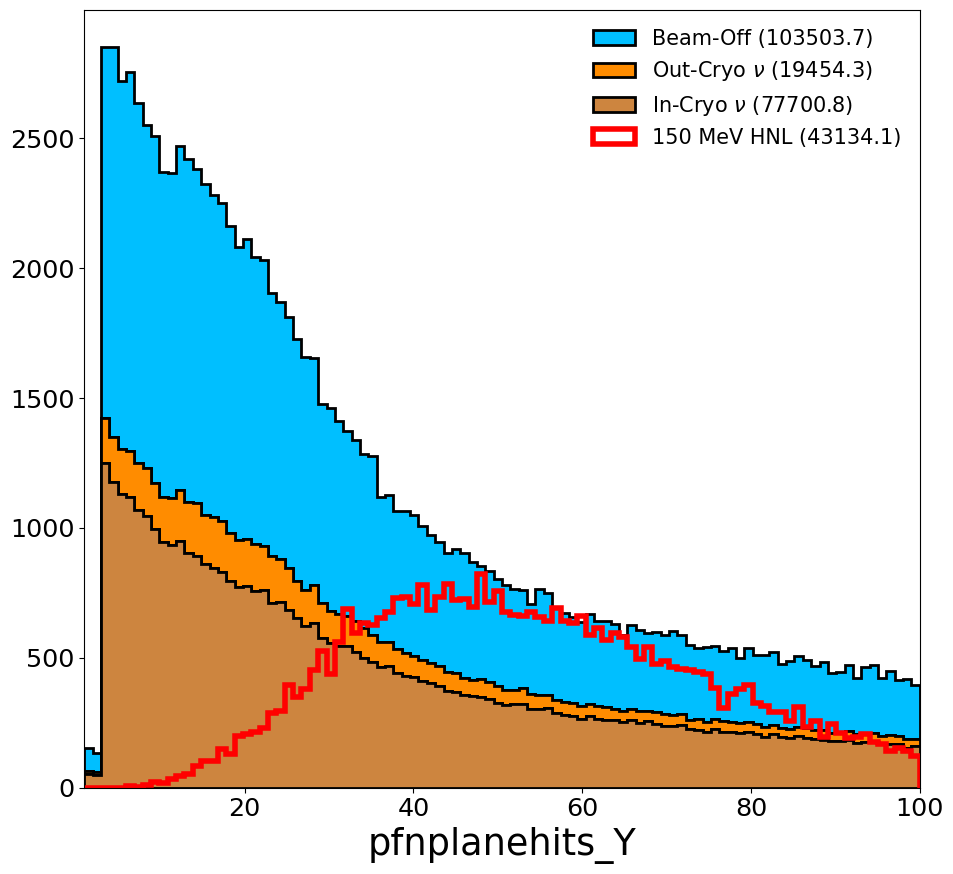

In [25]:
PT.Plot_preselection_variable(variable, samples_plotting, sample_norms, xlabel=[],xlims=[1,100],bins=100, HNL_mass=HNL_mass,
                              HNLplotscale=600000,cutline=0.0,legloc="upper right")

plt.savefig("plots/Preselection_variables/" + Params["Run"] + "_" + str(HNL_mass) + "_MeV_" + str(variable)+"_highest_E.png")

## Plot only signal samples before preselection

In [4]:
#Need a new plotting function for this


# Pre-selection cuts

In [49]:
def Preselection_weighted_efficiency(samples, cut_dict, Efficiency_dict, Preselected): #Need to account for weigthing in overlay and dirt samples
    for sample in samples:
        if sample == "overlay" or sample == "dirtoverlay" or sample in Constants.Detector_variations:
            weight = samples[sample]["weight"]
            NumEvs = sum(weight)
        else:
            NumEvs = len(samples[sample])
        
        effic_list = [1.0]
        for cut in cut_dict.keys():
            samples[sample]=samples[sample].query(cut_dict[cut])
            if sample == "overlay" or sample == "dirtoverlay" or sample in Constants.Detector_variations:
                weight = samples[sample]["weight"]
                Num_selected = sum(weight)
            else:
                Num_selected = len(samples[sample])
            effic_list.append(Num_selected/NumEvs)
        Efficiency_dict[sample]=effic_list
        #samples.update()
        Selected = samples[sample].copy()
        placeholder_dict = {sample:Selected}
        Preselected.update(placeholder_dict) 
    
def Preselection_DetVars(samples, cut_dict, Preselected): #Not making efficiency plots for DetVars
    for sample in samples:
        for cut in cut_dict.keys():
            samples[sample]=samples[sample].query(cut_dict[cut])
        Selected = samples[sample].copy()
        placeholder_dict = {sample:Selected}
        Preselected.update(placeholder_dict)

In [50]:
#Make cuts on signal
if Params["Run"] == "run1": 
    if Params["Load_pi0_signal"] == False:
        if Params["FLATTEN"] == True:
            Preselection_dict = Constants.Preselection_dict #Have also saved this in Constants.py, it is also here in case I want to add to or edit the cuts
        else:
            Preselection_dict = Constants.Preselection_dict_for_plot
    if Params["Load_pi0_signal"] == True:
        Preselection_dict = Constants.Preselection_dict_pi0
        
elif Params["Run"] == "run3":
    if Params["Load_pi0_signal"] == False:
        if Params["FLATTEN"] == True:
            Preselection_dict = Constants.Preselection_dict
        else:
            Preselection_dict = Constants.Preselection_dict_for_plot
    if Params["Load_pi0_signal"] == True:
        Preselection_dict = Constants.Preselection_dict_pi0
    Preselection_dict.update(Constants.Preselection_dict_crtveto) #Adding crtveto cut
        
print("Preselection is:" + "\n")
print(Preselection_dict)
print()


Preselection is:

{'nslice': 'nslice==1', 'flash_time': 'flash_time > 6.55 and flash_time < 16.5', 'nu_flashmatch_score': 'nu_flashmatch_score < 15', 'NeutrinoEnergy2': 'NeutrinoEnergy2 < 500', 'contained_fraction': 'contained_fraction > 0.9', 'trk_score': 'trk_score < 0.97', 'n_pfps': 'n_pfps < 6'}



In [51]:
sample_dict_copy = {}
for sample in samples_dict:
    sample_dict_copy[sample] = samples_dict[sample].copy()

Efficiency_dict = {}
Preselected_dict = {}
    
Preselection_weighted_efficiency(sample_dict_copy, Preselection_dict, Efficiency_dict, Preselected_dict)


## Detector Variations selection

In [53]:
#Working out the maximum and minimum efficiencies for signal "band"
Preselection_signal_max = []
Preselection_signal_min = []

max_presel_effic = 0.0 #Placeholder to record the highest efficiency
min_presel_effic = 1.0 #Placeholder to record the lowest efficiency

for i in range(len(Preselection_dict)+1):
    for HNL_mass in Constants.HNL_mass_samples: #Doesn't work for pi0 samples of course
        if Efficiency_dict[HNL_mass][i] > max_presel_effic:
            max_presel_effic = Efficiency_dict[HNL_mass][i]
        if Efficiency_dict[HNL_mass][i] < min_presel_effic:
            min_presel_effic = Efficiency_dict[HNL_mass][i]
    Preselection_signal_max.append(max_presel_effic)
    Preselection_signal_min.append(min_presel_effic)
    max_presel_effic = 0.0

In [54]:
print(Preselection_signal_max)
print(Preselection_signal_min)

[1.0, 0.6146315760281761, 0.5823234144041709, 0.5385052571753339, 0.5357772094344985, 0.4153193377520175, 0.4064449929282565, 0.40142544163731664]
[1.0, 0.39132676599093597, 0.37653667670764474, 0.3401720535156992, 0.33737686233004965, 0.24627533990067574, 0.24057640641537084, 0.24027789085185486]


In [7]:
print(Preselected_dict.keys())

dict_keys(['2_WireModX', '2_WireModYZ', '2_WireModThetaXZ', '2_WireModThetaYZ', '2_WireModdEdX', '2_LYDown', '2_LYRayleigh', '2_LYAttenuation', '2_SCE', '2_Recomb2', '2_CV', '10_WireModX', '10_WireModYZ', '10_WireModThetaXZ', '10_WireModThetaYZ', '10_WireModdEdX', '10_LYDown', '10_LYRayleigh', '10_LYAttenuation', '10_SCE', '10_Recomb2', '10_CV', '20_WireModX', '20_WireModYZ', '20_WireModThetaXZ', '20_WireModThetaYZ', '20_WireModdEdX', '20_LYDown', '20_LYRayleigh', '20_LYAttenuation', '20_SCE', '20_Recomb2', '20_CV', '50_WireModX', '50_WireModYZ', '50_WireModThetaXZ', '50_WireModThetaYZ', '50_WireModdEdX', '50_LYDown', '50_LYRayleigh', '50_LYAttenuation', '50_SCE', '50_Recomb2', '50_CV', '100_WireModX', '100_WireModYZ', '100_WireModThetaXZ', '100_WireModThetaYZ', '100_WireModdEdX', '100_LYDown', '100_LYRayleigh', '100_LYAttenuation', '100_SCE', '100_Recomb2', '100_CV', '180_WireModX', '180_WireModYZ', '180_WireModThetaXZ', '180_WireModThetaYZ', '180_WireModdEdX', '180_LYDown', '180_LYRa

## Only select highest energy object and "Prepare" for xgboost

In [8]:
def Prepare_dfs_for_xgb(df): #The default value for missing data in XGB is 0. So this changes those very large negative values to -9999.
    value = -1e15
    new_value = -9999
    first_entry = df.index[0]
    for variable in df.keys():
        if isinstance(df[variable][first_entry], (int,float,np.int32,np.float32,np.uint32)):
        # if variable=='rse_id': #Should come up with a better way of checking the "type" of variable, in case it is not int or float.
        #     continue           #But don't know how to access the first extant row of a dataframe (since some have been removed). 
        # else: 
            if(len(df.loc[df[variable] < value]) > 0):
                df.loc[(df[variable] < value), variable] = new_value #Sets the new value
            if(len(df.loc[df[variable] == -1.0]) > 0):
                df.loc[(df[variable] == -1.0), variable] = new_value #Sets the new value
            if(len(df.loc[df[variable] == np.nan]) > 0):
                df.loc[(df[variable] == np.nan), variable] = new_value #Sets the new value
            if(len(df.loc[df[variable] == np.inf]) > 0):
                df.loc[(df[variable] == np.inf), variable] = new_value #Sets the new value
        # else:
        #     print(variable)
            
    df_edited = df.copy() 
    return df_edited

def Sophisticated_dfs_for_xgb(df): #Requires a minimum of 2 reconstructed objects
    #Take highest E object
    print("Write this")
    variable = 'pfnplanehits_Y'
    # df.loc
    #Look at 2nd highest E object, if within x cm save these two
    #If not look for next highest E object and repeat. 
    #If exhausted of objects, remove event
    
    #Make event-wise variables to feed into BDT
    #Save opening angle
    #Save theta, phi of highest E object
    #Save theta, phi of lower E object
    #Save length of highest E object
    #Save length of lower E object
    #Save invariant mass of 2 objects
    #Save total E of both objects

In [9]:
Prepared_dict = {}
for sample in Preselected_dict:
    Highest_E_placeholder = Functions.only_keep_highest_E(Preselected_dict[sample])
    Prepared_dict[sample] = Functions.Prepare_dfs_for_xgb(Highest_E_placeholder)
print(Prepared_dict.keys())

dict_keys(['2_WireModX', '2_WireModYZ', '2_WireModThetaXZ', '2_WireModThetaYZ', '2_WireModdEdX', '2_LYDown', '2_LYRayleigh', '2_LYAttenuation', '2_SCE', '2_Recomb2', '2_CV', '10_WireModX', '10_WireModYZ', '10_WireModThetaXZ', '10_WireModThetaYZ', '10_WireModdEdX', '10_LYDown', '10_LYRayleigh', '10_LYAttenuation', '10_SCE', '10_Recomb2', '10_CV', '20_WireModX', '20_WireModYZ', '20_WireModThetaXZ', '20_WireModThetaYZ', '20_WireModdEdX', '20_LYDown', '20_LYRayleigh', '20_LYAttenuation', '20_SCE', '20_Recomb2', '20_CV', '50_WireModX', '50_WireModYZ', '50_WireModThetaXZ', '50_WireModThetaYZ', '50_WireModdEdX', '50_LYDown', '50_LYRayleigh', '50_LYAttenuation', '50_SCE', '50_Recomb2', '50_CV', '100_WireModX', '100_WireModYZ', '100_WireModThetaXZ', '100_WireModThetaYZ', '100_WireModdEdX', '100_LYDown', '100_LYRayleigh', '100_LYAttenuation', '100_SCE', '100_Recomb2', '100_CV', '180_WireModX', '180_WireModYZ', '180_WireModThetaXZ', '180_WireModThetaYZ', '180_WireModdEdX', '180_LYDown', '180_LYRa

# Save pkls

In [10]:
print_vals = input("Do you want to save the pickle files? y/n ")
if print_vals == "y":
    loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"
    
    for sample in Preselected_dict:
        print("Saving "+Params["Run"]+f" Preselected {sample} .pkl")
        if sample in Constants.Detector_variations:
            #Preselected_dict[sample].to_pickle(loc_pkls+"DetVars/"+"Preselected_overlay_"+Params["Run"]+"_"+Params["variables_string"]+f"_{sample}_"+Params["Flat_state"]+"_"+Params["Reduced_state"]+".pkl")
            Prepared_dict[sample].to_pickle(loc_pkls+"DetVars/"+"Preselected_overlay_"+Params["Run"]+"_"+Params["variables_string"]+
                                            f"_{sample}_"+Params["Flat_state"]+"_"+Params["Reduced_state"]+".pkl")
        if Params["Load_Signal_DetVars"] == True:
            Prepared_dict[sample].to_pickle(loc_pkls+"Signal_DetVars/"+"Preselected_"+Params["Run"]+f"_{sample}_"+Params["Reduced_state"]+".pkl")
        
        if Params["Load_pi0_signal"] == True:
            Prepared_dict[sample].to_pickle(loc_pkls+"pi0_selection/Preselected_"+Params["Run"]+
                                            f"_{sample}"+".pkl")
        
        else:
            #Preselected_dict[sample].to_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+".pkl")
            Prepared_dict[sample].to_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")

else:
    print("Not saving pickle files, move onto next cell")

Do you want to save the pickle files? y/n  y


Saving run3 Preselected 2_WireModX .pkl
Saving run3 Preselected 2_WireModYZ .pkl
Saving run3 Preselected 2_WireModThetaXZ .pkl
Saving run3 Preselected 2_WireModThetaYZ .pkl
Saving run3 Preselected 2_WireModdEdX .pkl
Saving run3 Preselected 2_LYDown .pkl
Saving run3 Preselected 2_LYRayleigh .pkl
Saving run3 Preselected 2_LYAttenuation .pkl
Saving run3 Preselected 2_SCE .pkl
Saving run3 Preselected 2_Recomb2 .pkl
Saving run3 Preselected 2_CV .pkl
Saving run3 Preselected 10_WireModX .pkl
Saving run3 Preselected 10_WireModYZ .pkl
Saving run3 Preselected 10_WireModThetaXZ .pkl
Saving run3 Preselected 10_WireModThetaYZ .pkl
Saving run3 Preselected 10_WireModdEdX .pkl
Saving run3 Preselected 10_LYDown .pkl
Saving run3 Preselected 10_LYRayleigh .pkl
Saving run3 Preselected 10_LYAttenuation .pkl
Saving run3 Preselected 10_SCE .pkl
Saving run3 Preselected 10_Recomb2 .pkl
Saving run3 Preselected 10_CV .pkl
Saving run3 Preselected 20_WireModX .pkl
Saving run3 Preselected 20_WireModYZ .pkl
Saving r

# Plotting Efficiencies

Do you want to save the figure? y/n  n


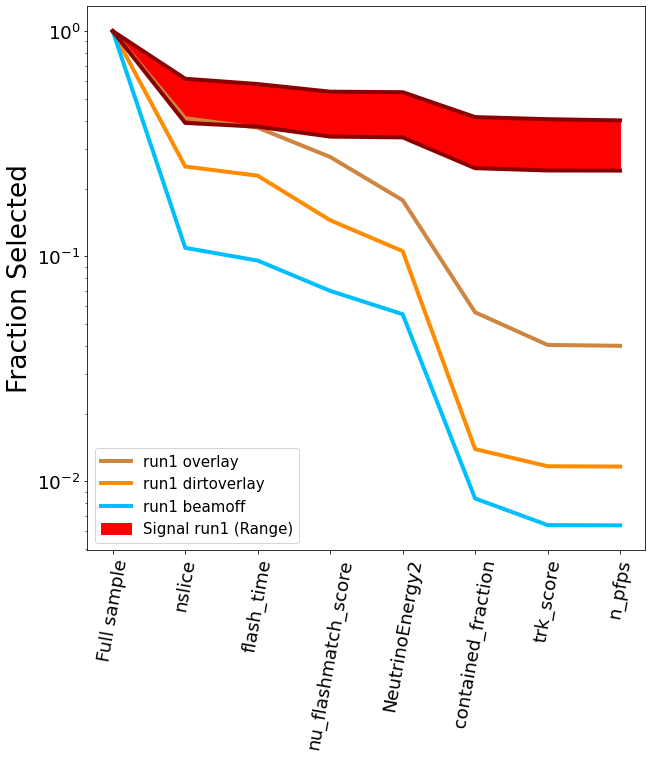

In [55]:
#Signal-only efficiencies
plt.figure(figsize=[10,10])
#print(Preselection_efficiency_signal_dict)
#print(len(Preselection_efficiency_signal_dict[HNL_mass]))
# for HNL_mass in HNL_masses:
#     plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)), Preselection_efficiency_signal_dict[HNL_mass], label=f"{HNL_mass} MeV HNL",lw=4,markersize=15)
#plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_signal,label="100 MeV HNL",lw=4,markersize=15)


# plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_overlay,label=f"MC {Run} overlay",color='peru',lw=4,markersize=15)
# plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_dirt,label=f"MC {Run} dirt",color="darkorange",lw=4,markersize=15)
# plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_EXT,label=f"{Run} EXT",color='deepskyblue',lw=4,markersize=15)
# plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_max,color="darkred",lw=4,marker="")
# plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_min,color="darkred",lw=4,marker="")
# plt.fill_between(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_min,Preselection_signal_max,label=f"Signal {Run} (Range)",color="red")
# plt.ylabel("Fraction Selected")
# plt.xticks(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
# #plt.yscale("log")
# plt.legend()

plotting_effic_dict = {'overlay':Efficiency_dict['overlay'], 'dirtoverlay':Efficiency_dict['dirtoverlay'],
                      'beamoff':Efficiency_dict['beamoff']}
plotting_effic_colours = {'overlay':'peru', 'dirtoverlay':'darkorange',
                      'beamoff':'deepskyblue'}
#, 'signal_max':Preselection_signal_max, 'signal_min':Preselection_signal_min}

log = True

if log == True:
    logscale="log"
elif log == False:
    logscale="linear"

for effic in plotting_effic_dict:
    #Efficiency_dict[effic]
    plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[effic],label=Params["Run"]+f" {effic}",color=plotting_effic_colours[effic],lw=4,markersize=15)

plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_max,color="darkred",lw=4,marker="")
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_min,color="darkred",lw=4,marker="")
plt.fill_between(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_min,Preselection_signal_max,label="Signal "+Params["Run"]+" (Range)",color="red")
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict['overlay'])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
plt.yscale(logscale)
plt.legend()

save_fig = input("Do you want to save the figure? y/n ")

if save_fig == 'y':
    plt.savefig("plots/Preselection_efficiencies/"+Params["Run"]+"_"+Params["Flat_state"]+"_" + logscale + ".png")

## Plotting single mass point and background

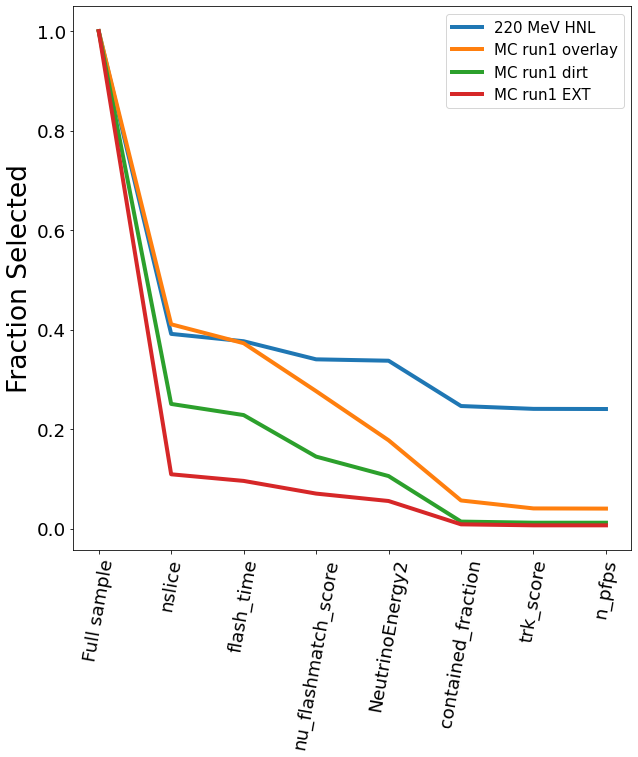

In [59]:
#Plotting efficiency
signal_mass = 220
plt.figure(figsize=[10,10])
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[signal_mass],label=f"{signal_mass} MeV HNL",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict['overlay'],label="MC run1 overlay",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict['dirtoverlay'],label="MC run1 dirt",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict['beamoff'],label="MC run1 EXT",lw=4,markersize=15)
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict[effic])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
#plt.yscale("log")
plt.legend()


## Plotting just signal

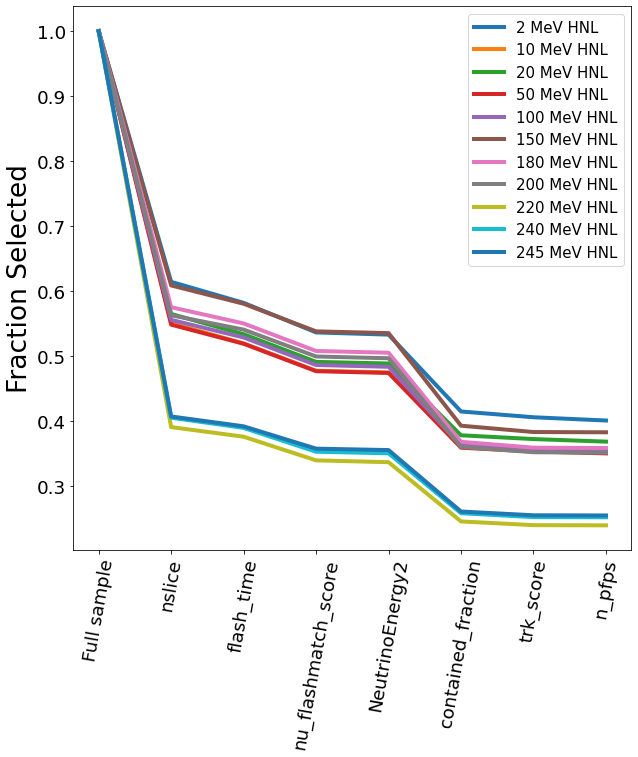

In [66]:
plt.figure(figsize=[10,10])

for HNL_mass in Constants.HNL_mass_samples:
    plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[HNL_mass],label=f"{HNL_mass} MeV HNL",lw=4,markersize=15)
    
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict[effic])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
# plt.yscale("log")
plt.legend()

plt.savefig("plots/Preselection_efficiencies/Signal_only_"+Params["Run"]+"_"+Params["Flat_state"]+".png")

# Testing code

In [ ]:
#Testing what the variables look like
variable = "dvtx_x_boundary"
def test_variables(df):
    test_signal = df[variable]
    print(type(test_signal))
    print(len(test_signal))
test_variables(df_overlay_run1)
test_variables(df_dirt_run1)
test_variables(df_EXT_run1)
test_variables(df_signal_run1)

In [ ]:
#print(overlay_from_pkl['nslice'])
#print("Flat Overlay .pkl is "+str(len(FLAT_overlay_from_pkl))+" entries long.")

print("-----Unflattened-----")
unique_var = overlay_from_pkl["nslice"].unique()
print(unique_var)
unique_var = overlay_from_pkl["n_pfps"].unique()
print(unique_var)
print(overlay_from_pkl["n_pfps"])
print(type(overlay_from_pkl["n_pfps"][0]))

# for var in overlay_from_pkl.keys():
#     if type(overlay_from_pkl[var][1]) == "numpy.ndarray":
#         print(var)

# print("-----Flattened-----")
# unique_var = FLAT_overlay_from_pkl["nslice"].unique()
# print(unique_var)
# unique_var = FLAT_overlay_from_pkl["n_pfps"].unique()
# print(unique_var)
# print(FLAT_overlay_from_pkl["n_pfps"])
# print(type(FLAT_overlay_from_pkl["n_pfps"]))